In [93]:
# -------------------------------------------------------------------------------------------------------------------- #
# external imports
# ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from matplotlib.ticker import FuncFormatter, MultipleLocator
from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar



In [94]:
# Defining pathes
PSRCpath =  
VehicleDatapath = 
EmissionDatapath = 

# Travel Demand Model

### Load data
Reading the data and filtering to only include Seattle travel data 

In [95]:
# Specify path for PSRC Household_Travel_Survey_Trips.csv
# PSRCpath = 

# Load the CSV file into a DataFrame
df = pd.read_csv(PSRCpath)

df_sea = df[(df['origin_jurisdiction'] == 'Seattle')]

df_sea_orig = df_sea.copy()
df_sea_orig2 = df_sea.copy()


C:\Users\Sophie Westphal\AppData\Local\Temp\ipykernel_23624\1180061563.py:5: DtypeWarning: Columns (7,8,10,13,18,22,28,39,41,42,43,45,46,49,50,54,55,61,62,63,64,65,66,67,68,70,71,72,75,79,83,84,85,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(PSRCpath)


### Cleaning of data 
We clean the Seattle data by excluding hvm values that are not relevant. (everything except MIT and PT) Further, we drop all rows that don't list the mode of transport. Additionally, we exclude long paths >= 100km as these trips most likely are not done in the boundaries of the city. 

In [96]:
# Mapping for MiD categories
mode_mapping = {
    # Zu Fuß
    "Walk (or jog/wheelchair)": 1,

    # Fahrrad
    "Bicycle or e-bike (rSurvey only)": 2,
    "Standard bicycle (my household's)": 2,
    "Electric bicycle (my household's)": 2,
    "Scooter or e-scooter (e.g., Lime, Bird, Razor)": 2,
    "Bike-share - electric bicycle": 2,
    "Bike-share - standard bicycle": 2,
    "Bike-share bicycle (rMove only)": 2,
    "Bicycle owned by my household (rMove only)": 2,
    "Borrowed bicycle (e.g., from a friend)": 2,
    "Borrowed bicycle (e.g., from a friend) (rMove only)": 2,
    "Other rented bicycle": 2,
    "Other rented bicycle (rMove only)": 2,

    # MIV Fahrer/Mitfahrer
    "Household vehicle 1": 4,
    "Household vehicle 2": 4,
    "Household vehicle 3": 4,
    "Household vehicle 4": 4,
    "Household vehicle 5": 4,
    "Household vehicle 6": 4,
    "Household vehicle 7": 4,
    "Household vehicle 8": 4,
    "Car from work": 4,
    "Other non-household vehicle": 4,
    "Friend/colleague's car": 4,
    "Other vehicle in household": 4,
    "Rental car": 4,
    "Carshare service (e.g., Turo, Zipcar, ReachNow)": 4,
    "Carshare service (e.g., Turo, Zipcar, Getaround, GIG)": 4,

    # ÖPV
    "Bus (public transit)": 5,
    "Private bus or shuttle": 5,
    "Taxi (e.g., Yellow Cab)": 5,
    "Vanpool": 5,
    "Urban Rail (e.g., Link light rail, monorail)": 5,
    "Urban Rail (e.g., Link light rail, monorail, streetcar)": 5,
    "School bus": 5,
    "Ferry or water taxi": 5,
    "Other rail (e.g., streetcar)": 5,
    "Other bus (rMove only)": 5,
    "Commuter rail (Sounder, Amtrak)": 5,
    "Paratransit": 5,

    # Keine Angabe/Andere
    "Missing: Non-response": 9,
    "Missing Response": 9,
    "Airplane or helicopter": 9,
    "Other hired service (Uber, Lyft, or other smartphone-app car service)": 9,
    "Other hired car service (e.g., black car, limo)": 9,
    "Other motorcycle/moped/scooter": 9,
    "Other mode (e.g., skateboard, kayak, motorhome, etc.)": 9,
    "Other rail": 9,
    "Other motorcycle in household": 9,
    "Other scooter, moped, skateboard": 9,
    "Vehicle ferry (took vehicle on board)": 9,
    "Segway or Onewheel/electric unicycle": 9
}

# Spalte 'mode_1_encoded' erstellen basierend auf dem Mapping
df_sea['hvm'] = df_sea['mode_1'].map(mode_mapping)


# Zeilen mit nicht zuordenbaren Werten entfernen
df_sea = df_sea.dropna(subset=['hvm'])



C:\Users\Sophie Westphal\AppData\Local\Temp\ipykernel_23624\718463636.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sea['hvm'] = df_sea['mode_1'].map(mode_mapping)


In [97]:
df_sea_orig['hvm'] = df_sea['mode_1'].map(mode_mapping)

In [98]:
mode_mapping = {
    # Zu Fuß
    "Walk (or jog/wheelchair)": 1,
    
    # Fahrrad
    "Bicycle or e-bike (rSurvey only)": 2,
    "Standard bicycle (my household's)": 2,
    "Electric bicycle (my household's)": 3,
    "Scooter or e-scooter (e.g., Lime, Bird, Razor)": 3,
    "Bike-share - electric bicycle": 3,
    "Bike-share - standard bicycle": 2,
    "Bike-share bicycle (rMove only)": 2,
    "Bicycle owned by my household (rMove only)": 2,
    "Borrowed bicycle (e.g., a friend's)": 2,
    "Borrowed bicycle (e.g., from a friend) (rMove only)": 2,
    "Other rented bicycle": 2,
    "Other rented bicycle (rMove only)": 2,
    
    # Moped/Mofa und Motorrad
    "Scooter or e-scooter (e.g., Lime, Bird, Razor)": 4,
    "Other motorcycle/moped/scooter": 5,
    "Other motorcycle (not my household's)": 5,
    "Motorrad/Moped (PAPI)": 5,
    "Motorrad (Mitfahrer)": 6,
    "Motorrad (Fahrer)": 7,
    
    # Pkw
    "Household vehicle 1": 9,
    "Household vehicle 2": 9,
    "Household vehicle 3": 9,
    "Household vehicle 4": 9,
    "Household vehicle 5": 9,
    "Household vehicle 6": 9,
    "Household vehicle 7": 9,
    "Household vehicle 8": 9,
    "Car from work": 9,
    "Other non-household vehicle": 8,
    "Friend/colleague's car": 8,
    "Other vehicle in household": 8,
    "Rental car": 9,
    "Carshare service (e.g., Turo, Zipcar, ReachNow)": 10,
    "Carshare service (e.g., Turo, Zipcar, Getaround, GIG)": 10,

    # Taxi
    "Taxi (e.g., Yellow Cab)": 11,

    # Öffentlicher Verkehr
    "Bus (public transit)": 13,
    "Private bus or shuttle": 13,
    "Vanpool": 13,
    "Urban Rail (e.g., Link light rail, monorail)": 15,
    "Urban Rail (e.g., Link light rail, monorail, streetcar)": 15,
    "School bus": 13,
    "Ferry or water taxi": 19,
    "Other rail (e.g., streetcar)": 14,
    "Commuter rail (Sounder, Amtrak)": 16,
    "Paratransit": 13,
    
    # Flugzeug
    "Airplane or helicopter": 23,

    # Sonstiges
    "Missing: Non-response": 99,
    "Missing Response": 99,
    "Other mode (e.g., skateboard, kayak, motorhome, etc.)": 24,
    "Segway or Onewheel/electric unicycle": 24,
    "Other hired service (Uber, Lyft, or other smartphone-app car service)": 24,
    "Other hired car service (e.g., black car, limo)": 24,
    "Vehicle ferry (took vehicle on board)": 24,
    "anderes": 24
}

# Anwendung des Mappings auf die Spalte 'mode_1'
df_sea['hvm_diff2'] = df_sea['mode_1'].map(mode_mapping)

# Entferne Zeilen mit nicht zuordenbaren Werten
df_sea = df_sea.dropna(subset=['hvm_diff2'])

In [99]:
df_sea_orig['hvm_diff2'] = df_sea['mode_1'].map(mode_mapping)

In [100]:
# Encoding so that it resembles MiD Regional Wege

# Include only city traffic and therefore take out LKW (17+18), Schiff/Fähre (19), Fernzug (20), Fernlinienbus (21), Reisebus (22), Flugzeug (23), andere (24) ('hvm_diff2' column equals) [position 71 in codebook]                                   
# Define the list of modes to exclude
modes_to_exclude = [
    "Walk (or jog/wheelchair)", "Bicycle or e-bike (rSurvey only)", 
    "Other mode (e.g., skateboard, kayak, motorhome, etc.)",
    "Ferry or water taxi", "Paratransit",
    "Scooter or e-scooter (e.g., Lime, Bird, Razor)", "Skateboard or rollerblade",
    "Standard bicycle (my household's)", "Electric bicycle (my household's)",
    "Personal scooter or moped (not shared)", "Scooter-share (e.g., Bird, Lime)", 
    "Bike-share - electric bicycle", "Other scooter, moped, skateboard",
    "Vehicle ferry (took vehicle on board)", "Segway or Onewheel/electric unicycle",
    "Borrowed bicycle (e.g., a friend's)", "Bike-share - standard bicycle",
    "Bike-share bicycle (rMove only)", "Bicycle owned by my household (rMove only)",
    "Borrowed bicycle (e.g., from a friend) (rMove only)", 
    "Other rented bicycle (rMove only)"
]


# Exclude rows where mode_1 matches any mode in the list
df_sea_clean = df_sea[~df_sea['mode_1'].isin(modes_to_exclude)]

# Drop rows where hvm equals 1, 2 and 9(Zu Fuß, Fahrrad, keine Angabe)                                             
df_sea_clean = df_sea_clean[~df_sea_clean['hvm'].isin([1, 2, 9])] # hvm = 9 = 106 entries


# Exclude long paths >= 100km, using wegkm_imp here as we would underestimate otherwise                           
df_sea_clean = df_sea_clean[(df_sea_clean['distance_miles'] < 62.137)]

# Date Encoding
df_sea_clean[['Month', 'Day', 'Year']] = df_sea_clean['depart_date'].str.split('/', expand=True)

df_sea_clean['ST_MONAT'] = df_sea_clean['Month'].fillna(0).astype(int)
df_sea_clean['ST_MONAT'] = df_sea_clean['ST_MONAT'].astype(int)
df_sea_clean['ST_TAG'] = df_sea_clean['Day'].fillna(0).astype(int)
df_sea_clean['ST_TAG'] = df_sea_clean['ST_TAG'].astype(int)
df_sea_clean['ST_JAHR'] = df_sea_clean['Year'].fillna(0).astype(int)
df_sea_clean['ST_JAHR'] = df_sea_clean['ST_JAHR'].astype(int)

# Woche encoding
df_sea_clean['depart_date'] = pd.to_datetime(df_sea_clean['depart_date'])
df_sea_clean['ST_WOCHE'] = df_sea_clean['depart_date'].dt.isocalendar().week

# Weekday Encoding
dow_mapping = {
    "Monday": 1,
    "Tuesday": 2,
    "Wednesday": 3,
    "Thursday": 4,
    "Friday": 5,
    "Saturday": 6,
    "Sunday": 7
}
df_sea_clean['ST_WOTAG'] = df_sea_clean['travel_dow'].map(dow_mapping)

# Arbeitswoche Encoding
work_mapping = {
    "Monday": 1,
    "Tuesday": 1,
    "Wednesday": 1,
    "Thursday": 1,
    "Friday": 1,
    "Saturday": 2,
    "Sunday": 2
}
df_sea_clean['arbwo'] = df_sea_clean['travel_dow'].map(work_mapping)


cal = USFederalHolidayCalendar()

# Generate a list of US federal holidays for the relevant range
# Assume that your dataset includes years, or set a fixed range
holidays = cal.holidays(start='2017-01-01', end='2019-12-31')
holiday_weekdays = pd.to_datetime(holidays).strftime('%A').tolist()
df_sea_clean['feiertag'] = df_sea_clean['travel_dow'].isin(holiday_weekdays).astype(int)
df_sea_clean['feiertag'] = df_sea_clean['feiertag'].map({1: 0, 0: 1})


# Funktion zur Zuordnung von Monaten zu Jahreszeiten
def get_season(month):
    if month in [12, 1, 2]:  # Winter: Dezember, Januar, Februar
        return 1  # Winter
    elif month in [3, 4, 5]:  # Frühling: März, April, Mai
        return 2  # Frühling
    elif month in [6, 7, 8]:  # Sommer: Juni, Juli, August
        return 3  # Sommer
    elif month in [9, 10, 11]:  # Herbst: September, Oktober, November
        return 4  # Herbst
df_sea_clean['saison'] = df_sea_clean['Month'].apply(get_season)

# Fülle fehlende Werte mit einem Standardwert (z. B. 0)
df_sea_clean['depart_time_hour'] = df_sea_clean['depart_time_hour'].fillna(0).astype(int)
df_sea_clean['depart_time_minute'] = df_sea_clean['depart_time_minute'].fillna(0).astype(int)

df_sea_clean['W_SZ'] = pd.to_datetime(
    df_sea_clean['depart_time_hour'].astype(str) + ':' +
    df_sea_clean['depart_time_minute'].astype(str).str.zfill(2) + ':00',
    format='%H:%M:%S'
).dt.time

purpose_mapping = {
    # Arbeit/Geschäftlich
    "Went to primary workplace": 1,
    "Went to work-related place (e.g., meeting, second job, delivery)": 1,
    "Went to other work-related activity": 1,
    # Ausbildung
    "Went to school/daycare (e.g., daycare, K-12, college)": 2,
    # Besorgung und Service
    "Went grocery shopping": 3,
    "Went to other shopping (e.g., mall, pet store)": 3,
    "Went to medical appointment (e.g., doctor, dentist)": 3,
    "Other appointment/errands (rMove only)": 3,
     # Freizeit
    "Attended social event (e.g., visit with friends, family, co-workers)": 4,
    "Went to restaurant to eat/get take-out": 4,
    "Attended recreational event (e.g., movies, sporting event)": 4,
    "Went to exercise (e.g., gym, walk, jog, bike ride)": 4,
    "Went to religious/community/volunteer activity": 4,
    "Went to a family activity (e.g., child's softball game)": 4,
    "Other social/leisure (rMove only)": 4,
    # Nach Hause/Sonstiges
    "Went home": 5,
    "Dropped off/picked up someone (e.g., son at a friend's house, spouse at bus stop)": 5,
    "Other purpose": 5,
    "Transferred to another mode of transportation (e.g., change from ferry to bus)": 5,
}
df_sea_clean['zweck_mop'] = df_sea_clean['dest_purpose'].map(purpose_mapping)
df_sea_clean = df_sea_clean.dropna(subset=['zweck_mop'])
# Miles in km
df_sea_clean['wegkm'] = df_sea_clean['distance_miles'] * 1.60934
df_sea_clean['wegkm_imp'] = df_sea_clean['distance_miles'] * 1.60934



In [101]:
df_sea_orig[['Month', 'Day', 'Year']] = df_sea_orig['depart_date'].str.split('/', expand=True)

df_sea_orig['ST_MONAT'] = df_sea_orig['Month'].fillna(0).astype(int)
df_sea_orig['ST_MONAT'] = df_sea_orig['ST_MONAT'].astype(int)
df_sea_orig['ST_TAG'] = df_sea_orig['Day'].fillna(0).astype(int)
df_sea_orig['ST_TAG'] = df_sea_orig['ST_TAG'].astype(int)
df_sea_orig['ST_JAHR'] = df_sea_orig['Year'].fillna(0).astype(int)
df_sea_orig['ST_JAHR'] = df_sea_orig['ST_JAHR'].astype(int)
df_sea_orig['zweck_mop'] = df_sea_orig['dest_purpose'].map(purpose_mapping)
df_sea_orig['wegkm'] = df_sea_orig['distance_miles'] * 1.60934
df_sea_orig['wegkm_imp'] = df_sea_orig['distance_miles'] * 1.60934
df_sea_orig['ST_WOTAG'] = df_sea_orig['travel_dow'].map(dow_mapping)
df_sea_orig['arbwo'] = df_sea_orig['travel_dow'].map(work_mapping)
df_sea_orig['depart_date'] = pd.to_datetime(df_sea_orig['depart_date'])
df_sea_orig['ST_WOCHE'] = df_sea_orig['depart_date'].dt.isocalendar().week
df_sea_orig['feiertag'] = df_sea_orig['travel_dow'].isin(holiday_weekdays).astype(int)
df_sea_orig['feiertag'] = df_sea_orig['feiertag'].map({1: 0, 0: 1})
df_sea_orig['saison'] = df_sea_orig['Month'].apply(get_season)
# Fülle fehlende Werte mit einem Standardwert (z. B. 0)
df_sea_orig['depart_time_hour'] = df_sea_orig['depart_time_hour'].fillna(0).astype(int)
df_sea_orig['depart_time_minute'] = df_sea_orig['depart_time_minute'].fillna(0).astype(int)
df_sea_orig['W_SZ'] = pd.to_datetime(
    df_sea_orig['depart_time_hour'].astype(str) + ':' +
    df_sea_orig['depart_time_minute'].astype(str).str.zfill(2) + ':00',
    format='%H:%M:%S'
).dt.time


In [102]:
selected_columns = ["ST_MONAT","ST_TAG","ST_JAHR","ST_WOTAG","ST_WOCHE","arbwo","feiertag","saison","W_SZ","zweck_mop","wegkm","wegkm_imp","hvm","hvm_diff2","trip_weight"]
df_sea_clean = df_sea_clean[selected_columns]


In [103]:
df_sea_orig = df_sea_orig[selected_columns]

### Cleaning of data 2
We drop all rows that don't have a starting time as these rows are unusable for our analysis. We change the index to datetime, round 'W_SZ' to 30min and sort the data by 'ST_WOTAG', 'W_SZ' and 'wegkm_imp' to prepare for further processing.

In [104]:
# Replace blanks with NaN values
df_sea_sort = df_sea_clean.replace(' ', np.nan)

# Drop rows with NaN values in 'W_SZ' column                                                                      
df_sea_sort.dropna(subset=['W_SZ'], inplace=True)

# Convert 'W_SZ' column to datetime with time only
df_sea_sort['W_SZ'] = pd.to_datetime(df_sea_sort['W_SZ'], format='%H:%M:%S', errors='coerce')

# Drop rows with NaT values in 'W_SZ' column
df_sea_sort = df_sea_sort.dropna(subset=['W_SZ'])

# Round 'W_SZ' to nearest 60 minutes 
df_sea_sort['W_SZ'] = df_sea_sort['W_SZ'].dt.floor('60min')#.dt.strftime('%H:%M:%S')


# Sort df by datetime in 'W_SZ' column
df_sea_sort = df_sea_sort.sort_values(by=["ST_WOTAG", 'W_SZ', 'wegkm_imp'])

# Reorder columns
new_column_order = ["ST_WOCHE", "ST_WOTAG", "W_SZ", "wegkm_imp", "wegkm", "ST_MONAT", "ST_JAHR", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo","trip_weight"]
df_sea_sort = df_sea_sort[new_column_order]


### Compensation Factor

#### First Compensation Factor
Calculating first compensation factor (factor_9_703_hoch) to counteract underestimation of wegkm_imp_hoch after eliminating data without mode of transport (hvm = 9, 703). We assume that the distribution of mode of transport for hvm = 9, 703 is the same as in the data with mode of transport. (we use wegkm_imp_hoch for calculation)

In [105]:
### Preparation of the data for the calculation of factor_9_703_hoch
selected_columns = ["hvm", "hvm_diff2", "ST_MONAT", "ST_JAHR", "ST_WOTAG", "ST_WOCHE", "W_SZ", "wegkm", "wegkm_imp", "saison", "arbwo", "feiertag", "zweck_mop"]
df_sea_factor_9_703 = df_sea_orig[selected_columns].copy()

# Replace values where hvm is 4 with 3
df_sea_factor_9_703.loc[df_sea_factor_9_703['hvm'] == 4, 'hvm'] = 3

df_sea_factor_9_703 = df_sea_factor_9_703[(df_sea_factor_9_703['wegkm_imp'] < 62.137)]

df_sea_factor_9_703 = df_sea_factor_9_703[~df_sea_factor_9_703['hvm_diff2'].isin(range(17, 25))]

# Calculate wegkm_imp_hoch 
df_sea_factor_9_703['wegkm_imp_hoch'] =  df_sea_factor_9_703['wegkm_imp']

# Calculate sum of wegkm_imp_hoch for all hvm values and store them in a new DataFrame
df_hvm_sums = df_sea_factor_9_703.groupby('hvm')['wegkm_imp_hoch'].sum().reset_index(name='sum_hvm_wegkm')

# Calculate sum of wegkm_imp_hoch for 9 and 703
sum_hvm_9_703 = df_hvm_sums[df_hvm_sums['hvm'].isin([9,703])]['sum_hvm_wegkm'].sum()

# Sum the sums of 1,2,3,5 and divide each sum by the total sum
sum_hvm_1_2_3_5 = df_hvm_sums[df_hvm_sums['hvm'].isin([1, 2, 3, 5])]['sum_hvm_wegkm'].sum()
df_hvm_sums['share'] = df_hvm_sums[df_hvm_sums['hvm'].isin([1, 2, 3, 5])]['sum_hvm_wegkm'] / sum_hvm_1_2_3_5

# Calculation of lost kilometers that are attributable to hvm = 3 and hvm = 5 respectively
lost_wegkm_3 = np.ceil(sum_hvm_9_703 * df_hvm_sums[df_hvm_sums['hvm'] == 3]['share'].values[0])
lost_wegkm_5 = np.ceil(sum_hvm_9_703 * df_hvm_sums[df_hvm_sums['hvm'] == 5]['share'].values[0])
lost_wegkm_3_5 = lost_wegkm_3 + lost_wegkm_5

# Calculate the compensation factor for hvm 3 and 5 combined
sum_hvm_3_5 = df_hvm_sums[df_hvm_sums['hvm'].isin([3, 5])]['sum_hvm_wegkm'].sum()

# We only have one compensation factor because we don't know the split between hvm = 3 and hvm = 5
factor_9_703_hoch = (lost_wegkm_3_5 + sum_hvm_3_5) / sum_hvm_3_5

#### Second and third compensation factor
Calculating second and third compensation factor for hvm = 3 (factor_3_no_SZ_hoch) and hvm = 5 (factor_5_no_SZ_hoch) to counteract underestimation of wegkm_imp_hoch after eliminating data without a starting time. (using wegkm_imp_hoch for calculation)

In [106]:
df_sea_orig2['hvm'] = df_sea_orig2['mode_1'].map(mode_mapping)
df_sea_orig2['hvm_diff2'] = df_sea_orig2['mode_1'].map(mode_mapping)
df_sea_orig2[['Month', 'Day', 'Year']] = df_sea_orig2['depart_date'].str.split('/', expand=True)

df_sea_orig2['ST_MONAT'] = df_sea_orig2['Month'].fillna(0).astype(int)
df_sea_orig2['ST_MONAT'] = df_sea_orig2['ST_MONAT'].astype(int)
df_sea_orig2['ST_TAG'] = df_sea_orig2['Day'].fillna(0).astype(int)
df_sea_orig2['ST_TAG'] = df_sea_orig2['ST_TAG'].astype(int)
df_sea_orig2['ST_JAHR'] = df_sea_orig2['Year'].fillna(0).astype(int)
df_sea_orig2['ST_JAHR'] = df_sea_orig2['ST_JAHR'].astype(int)
df_sea_orig2['zweck_mop'] = df_sea_orig2['dest_purpose'].map(purpose_mapping)
df_sea_orig2['wegkm'] = df_sea_orig2['distance_miles'] * 1.60934
df_sea_orig2['wegkm_imp'] = df_sea_orig2['distance_miles'] * 1.60934
df_sea_orig2['ST_WOTAG'] = df_sea_orig2['travel_dow'].map(dow_mapping)
df_sea_orig2['arbwo'] = df_sea_orig2['travel_dow'].map(work_mapping)
df_sea_orig2['depart_date'] = pd.to_datetime(df_sea_orig2['depart_date'])
df_sea_orig2['ST_WOCHE'] = df_sea_orig2['depart_date'].dt.isocalendar().week
df_sea_orig2['feiertag'] = df_sea_orig2['travel_dow'].isin(holiday_weekdays).astype(int)
df_sea_orig2['feiertag'] = df_sea_orig2['feiertag'].map({1: 0, 0: 1})
df_sea_orig2['saison'] = df_sea_orig2['Month'].apply(get_season)
# Fülle fehlende Werte mit einem Standardwert (z. B. 0)
df_sea_orig2['depart_time_hour'] = df_sea_orig2['depart_time_hour'].fillna(0).astype(int)
df_sea_orig2['depart_time_minute'] = df_sea_orig2['depart_time_minute'].fillna(0).astype(int)

In [107]:
### Preparation of the data for the calculation of factor_9_703_hoch
selected_columns = ["hvm", "hvm_diff2", "ST_MONAT", "ST_JAHR", "ST_WOTAG", "ST_WOCHE", "depart_time_hour", "wegkm", "wegkm_imp", "saison", "arbwo", "feiertag", "zweck_mop"]
df_sea_factor_9_703 = df_sea_orig2[selected_columns].copy()
df_sea_factor_9_703['wegkm_imp_hoch'] =  df_sea_factor_9_703['wegkm_imp']

In [108]:
# Drop rows where hvm equals 1, 2 and 9(Zu Fuß, Fahrrad, keine Angabe)                                              -> 28323 entries
df_sea_factor_no_SZ = df_sea_factor_9_703[~df_sea_factor_9_703['hvm'].isin([1, 2, 9])] # hvm = 9 = 106 entries

# Drop rows where hvm equals 703 (Weg ohne Detail) as we cant use this data                                         -> 25774 entries
df_sea_factor_no_SZ = df_sea_factor_no_SZ[~df_sea_factor_no_SZ['hvm'].isin([703])] # hvm = 703 = 2549 entries

# Replace blanks with NaN values
df_sea_factor_no_SZ = df_sea_factor_no_SZ.replace(' ', np.nan)

# Filter by 'W_SZ' column and only include rows where 'W_SZ' is NaN
df_sea_only_no_SZ = df_sea_factor_no_SZ[df_sea_factor_no_SZ['depart_time_hour'].isna()]

sum_wegkm_imp_hoch_no_SZ = df_sea_only_no_SZ['wegkm_imp_hoch'].sum()

sum_wegkm_imp_hoch_no_SZ_3 = df_sea_only_no_SZ[df_sea_only_no_SZ['hvm'] == 3]['wegkm_imp_hoch'].sum()
sum_wegkm_imp_hoch_no_SZ_5 = df_sea_only_no_SZ[df_sea_only_no_SZ['hvm'] == 5]['wegkm_imp_hoch'].sum()

sum_wegkm_imp_hoch_3 = df_sea_factor_no_SZ[df_sea_factor_no_SZ['hvm'] == 3]['wegkm_imp_hoch'].sum()
sum_wegkm_imp_hoch_5 = df_sea_factor_no_SZ[df_sea_factor_no_SZ['hvm'] == 5]['wegkm_imp_hoch'].sum()

# Calculating the compensation factor for hvm = 3 and hvm = 5 for no 'W_SZ' values (how many wegkm are lost in relative terms by missing starting times for hvm = 3 and hvm = 5)
factor_3_no_SZ_hoch =  sum_wegkm_imp_hoch_3 / (sum_wegkm_imp_hoch_3 - sum_wegkm_imp_hoch_no_SZ_3)
factor_5_no_SZ_hoch = sum_wegkm_imp_hoch_5 / (sum_wegkm_imp_hoch_5 - sum_wegkm_imp_hoch_no_SZ_5)


#### Inclusion of compensation factors
We include factor_9_703_hoch, factor_3_no_SZ_hoch, factor_5_no_SZ_hoch in df_sea_sort

In [109]:
# Create a new column for factor_9_703_hoch
df_sea_sort['factor_9_703_hoch'] = factor_9_703_hoch

# Create a new column for factor_3_no_SZ_hoch and factor_5_no_SZ_hoch
df_sea_sort['factor_no_SZ_hoch'] = np.nan

# Apply factor_3_no_SZ_hoch for entries where hvm == 3
df_sea_sort.loc[df_sea_sort['hvm'] == 3, 'factor_no_SZ_hoch'] = factor_3_no_SZ_hoch

# Apply factor_5_no_SZ_hoch for entries where hvm == 5
df_sea_sort.loc[df_sea_sort['hvm'] == 5, 'factor_no_SZ_hoch'] = factor_5_no_SZ_hoch

#### Extrapolation of wegkm
Next we calculate 'wegkm_imp_hoch' (wegkm extrapolated for the total Seattle population) by multiplying 'wegkm_imp' with the provided extrapolation factor 'W_HOCH' and the three compensation factors.

In [110]:
# Add a new column 'wegkm_imp_hoch' which is the product of 'W_HOCH' and 'wegkm_imp'
# Rounding up to lessen the effect of underestimation
df_sea_sort['wegkm_imp_hoch'] =  df_sea_sort['factor_9_703_hoch'] * df_sea_sort['wegkm_imp'] * df_sea_sort['trip_weight']

# Specify the new column order
new_column_order = ["ST_WOCHE", "ST_WOTAG", "W_SZ", "wegkm_imp_hoch",  "wegkm_imp", "wegkm", "ST_MONAT", "ST_JAHR", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo", "factor_9_703_hoch", "factor_no_SZ_hoch",'trip_weight']

# Reassign the DataFrame to the new column order
df_sea_sort = df_sea_sort[new_column_order]

#### Scaling of extrapolation factors
As the extrapolation factors are calculated for one sample day, we have to multiply the wegkm_imp_hoch by 7 because we split the data into 7 days and therefore roughly only have 1/7 of total wegkm per day. Below, three different approaches are discussed.

#### Calculate weekly km
Multiplying all wegkm_imp_hoch values by 7 to account for the split into 7 days

In [111]:
# Create 'wegkm_imp_hoch_fac' column -> Multiply all wegkm_imp_hoch values by 7 to account for the split into 7 days
df_sea_sort['wegkm_imp_hoch_fac'] = df_sea_sort['wegkm_imp_hoch'] * 1

# Specify the new column order
new_column_order = ["ST_WOCHE", "ST_WOTAG","W_SZ", "wegkm_imp_hoch", "wegkm_imp_hoch_fac",  "wegkm_imp", "wegkm",  "ST_MONAT", "ST_JAHR", "feiertag", "saison", "zweck_mop", "hvm", "hvm_diff2", "arbwo", "factor_9_703_hoch", "factor_no_SZ_hoch"]

# Reassign the DataFrame to the new column order
df_sea_sort = df_sea_sort[new_column_order]

In [112]:
# Function to format y-axis ticks as millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

In [113]:
# Group by 'ST_WOTAG' and calculate the sum for 'wegkm_imp_hoch_fac'
total_wegkm_day = df_sea_sort.groupby('ST_WOTAG')['wegkm_imp_hoch_fac'].sum().reset_index()

# Rename the columns for better clarity
total_wegkm_day.columns = ['Day of Week', 'Total wegkm_imp_hoch_fac']

# Optionally, map numeric days to weekday names
weekday_names = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
total_wegkm_day['Day of Week'] = total_wegkm_day['Day of Week'].map(weekday_names)


### Exponential smoothing of data
Applying Holt-Winters Exponential Smoothing to the dataset before aggregation and saving aggregated data of plots in dictionary with dfs for each day. (dfs_tot_MIT_PT_nohw_hw)

In [114]:
# Mapping dictionary for hvm labels
hvm_labels = {
    3: "MIV",
    5: "ÖPNV",
}

# Mapping dictionary for ST_WOTAG to weekday names
weekday_names = {
    1: "Monday",
    2: "Tuesday",
    3: "Wednesday",
    4: "Thursday",
    5: "Friday",
    6: "Saturday",
    7: "Sunday"
}
# Dictionary to store DataFrames for each day
dfs_tot_MIT_PT_nohw_hw = {}

# Function to smooth and aggregate data
def smooth_and_aggregate(group, col, periods):
    model = ExponentialSmoothing(
        group[col],
        seasonal='add',
        seasonal_periods=periods
    )
    fitted_model = model.fit(optimized=True)
    group[f'HW_{col}'] = fitted_model.fittedvalues
    aggregated_smoothed = group.groupby('W_SZ')[f'HW_{col}'].sum().reset_index()
    aggregated_original = group.groupby('W_SZ')[col].sum().reset_index()
    return aggregated_smoothed, aggregated_original

# Group by 'ST_WOTAG' and apply the smoothing function
for name, group in df_sea_sort.groupby('ST_WOTAG'):

    # Aggregate original and smoothed 'wegkm_imp_hoch_fac' data
    aggregated_smoothed, aggregated_group = smooth_and_aggregate(group.copy(), 'wegkm_imp_hoch_fac', periods)
    
    # Combine aggregated and smoothed data into one DataFrame
    combined_df = pd.merge(aggregated_group, aggregated_smoothed, on='W_SZ')
    
    # Aggregate original and smoothed 'MIV' data if available
    miv_group = group[group['hvm'] == 4].copy()  # Prevent SettingWithCopyWarning
    if not miv_group.empty:
        miv_smoothed, miv_original = smooth_and_aggregate(miv_group, 'wegkm_imp_hoch_fac', periods)
        combined_df = pd.merge(combined_df, miv_original, on='W_SZ', how='left', suffixes=('', '_MIV'))
        combined_df = pd.merge(combined_df, miv_smoothed, on='W_SZ', how='left', suffixes=('', '_MIV'))
        
    # Aggregate original and smoothed 'MIV' data if available
    pt_group = group[group['hvm'] == 5].copy()  # Prevent SettingWithCopyWarning
    if not pt_group.empty:
        pt_smoothed, pt_original = smooth_and_aggregate(pt_group, 'wegkm_imp_hoch_fac', periods)
        combined_df = pd.merge(combined_df, pt_original, on='W_SZ', how='left', suffixes=('', '_PT'))
        combined_df = pd.merge(combined_df, pt_smoothed, on='W_SZ', how='left', suffixes=('', '_PT'))
    
    # Store the combined DataFrame in the dictionary
    day_name = weekday_names.get(name, "Unknown")
    dfs_tot_MIT_PT_nohw_hw[day_name] = combined_df

C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Opti

### Interpolation of values
Interpolating values.

In [115]:
# Copying dictionary to avoid overwriting the original data
dfs_interpolated = dfs_tot_MIT_PT_nohw_hw.copy()

# Create a full time index by including missing times and reindexing, and fill missing values with NaN
full_time_index = pd.date_range(start='1900-01-01 00:00:00', end='1900-01-01 23:00:00', freq='60T')
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.set_index('W_SZ').reindex(full_time_index)
    
# Interpolate missing values with method='time' in dfs_interpolated for all days
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.interpolate(method='time')
    
# ONLY NEEDED FOR 30 MINUTE INTERVALS: Manually calculate the missing value on Monday at 00:00:00 for MIV (idea of wrap around time interpolation) 
# dfs_interpolated['Monday'].iloc[0]['wegkm_imp_hoch_fac_HW_MIV'] = (dfs_interpolated['Monday'].iloc[1]['wegkm_imp_hoch_fac_HW_MIV'] + dfs_interpolated['Monday'].iloc[-1]['wegkm_imp_hoch_fac_HW_MIV']) / 2 
# Manually calculate the missing value on Wednesday at 00:00:00 for PT
# dfs_interpolated['Wednesday'].iloc[0]['wegkm_imp_hoch_fac_HW_PT'] = (dfs_interpolated['Wednesday'].iloc[1]['wegkm_imp_hoch_fac_HW_PT'] + dfs_interpolated['Wednesday'].iloc[-1]['wegkm_imp_hoch_fac_HW_PT']) / 2

In [116]:
# Copying dictionary to avoid overwriting the original data
dfs_interpolated = dfs_tot_MIT_PT_nohw_hw.copy()

# Create a full time index by including missing times and reindexing, and fill missing values with NaN
full_time_index = pd.date_range(start='1900-01-01 00:00:00', end='1900-01-01 23:00:00', freq='60T')

for day, df in dfs_interpolated.items():
    # Reindex to include missing times
    df = df.set_index('W_SZ').reindex(full_time_index)
    
    # Replace all NaN values with zero
    df = df.fillna(0)
    
    # Store back to the dictionary
    dfs_interpolated[day] = df

# Interpolate missing values with method='time' in dfs_interpolated for all days
for day, df in dfs_interpolated.items():
    dfs_interpolated[day] = df.interpolate(method='time')


### Calculating daily values

In [117]:

# Initialize DataFrame to collect daily totals
daily_totals = pd.DataFrame()

# Calculate daily totals from dfs_interpolated
for day, df in dfs_interpolated.items():
    # Sum each column for the current day to get total values
    day_total = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT']].sum().to_frame().T
    day_total['Day'] = day  # Add day information
    daily_totals = pd.concat([daily_totals, day_total], ignore_index=True)

# Ensure 'Day' is treated as a categorical variable to control the order
daily_totals['Day'] = pd.Categorical(daily_totals['Day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Sort by 'Day' to ensure correct plotting order
daily_totals = daily_totals.sort_values('Day')


# Price Elasticity Model

**Formula:**

$$
C_{vd} = (FC_{vd} + OHC_{vd}) + (VC_{vkm} \cdot vkm_{tot/d}) + (VSC_{vh} \cdot DT_{h/d})
$$

### Initializing of data

In [119]:
# Load parameter data from Excel
params_df = pd.read_excel(VehicleDatapath, sheet_name='BaseValuesSeattle', index_col='Parameter')

# Load the exchange rate from the "BerlinExchangeRate" sheet
# Try loading with header=None if unsure about the format
exchange_rate_df = pd.read_excel(VehicleDatapath, sheet_name='BerlinExchangeRate', header=None)
#print(exchange_rate_df)  # This will help us understand the data structure
exchange_rate = exchange_rate_df.iloc[1, 0]

# Convert DataFrame to a dictionary for base values
pricing_values = params_df['Base Value'].to_dict()

# Extract individual values from the dictionary
r = pricing_values['r']       # Profit Margin (3%) (gleich wie aus der vorherigen Zelle)
p = pricing_values['p']       # Transaction fee (0.44%) (gleich wie aus der vorherigen Zelle)
VAT = pricing_values['VAT']   # VAT (19%) (Deutschland)
C_conv_priv = pricing_values['C_conv_priv'] #* exchange_rate
C_conv_bus = pricing_values['C_conv_bus'] #* exchange_rate
C_AE_ind_taxi = pricing_values['C_AE_ind_taxi'] #* exchange_rate
C_AE_pool_taxi = pricing_values['C_AE_pool_taxi'] #* exchange_rate

P_conv_priv = (C_conv_priv / ((1 - r) * (1 - p)))  * (1 + VAT)
P_conv_bus = (C_conv_bus / ((1 - r) * (1 - p)))  * (1 + VAT)
P_AE_ind_taxi = (C_AE_ind_taxi / ((1 - r) * (1 - p)))  * (1 + VAT)
P_AE_pool_taxi= (C_AE_pool_taxi / ((1 - r) * (1 - p)))  * (1 + VAT)



In [120]:
# Calculate the blocks for the waterfall
additional_block = 0
first_block = P_conv_priv - P_AE_ind_taxi

second_block = (P_AE_ind_taxi-(P_AE_ind_taxi - 0.01))
third_block = (P_AE_ind_taxi - 0.01) - P_AE_pool_taxi
fourth_block = P_AE_pool_taxi

# Define the initial total value and the blocks
total_value = P_conv_priv
blocks = [additional_block, first_block , second_block, third_block, fourth_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]
for block in blocks:
    cumulative.append(cumulative[-1] - block)



In [121]:
# Price elasticities taken from literature -> khanna2023 (fuel price elasticity)
e_MIV = float(- 0.435)

In [122]:
# Set 'W_SZ' as index for all DataFrames in the dictionary dfs_tot_MIT_PT_nohw_hw
for day, df in dfs_tot_MIT_PT_nohw_hw.items():
    dfs_tot_MIT_PT_nohw_hw[day] = df.set_index('W_SZ')

### Assumptions for the calculation of SAEV demand
1. Total travel demand is inelastic and remains constant
2. The difference between D_MIT_AE_S and D_MIT is the additional demand for SAEVs for which we calculate the energy consumption



**Formula:**

$$
D_{\text{individual, AEV, t=2}} = \epsilon_{\text{individual}} \cdot D_{\text{individual, t=1}} \cdot \Delta P_{\text{individual, AEV, t=2}} + D_{\text{individual, t=1}}
$$

## Scenario 1

In [123]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_values_scenario1(row):  
    # Preiselastizität (-) * wegkm * Preisunterschied pro km (-) + wegkm (Berechnung zusätzliche wegkm durch geringeren Preis)
    d_miv_ae = e_MIV * row['wegkm_imp_hoch_fac_MIV'] * (P_AE_ind_taxi - P_conv_priv) + row['wegkm_imp_hoch_fac_MIV'] # Demand MIV autonomous electric
       
    # Preiselastizität (-) * wegkm * Preisunterschied pro km (-) + wegkm (Berechnung zusätzliche wegkm durch geringeren Preis)
    d_miv_ae_s = e_MIV * d_miv_ae * (P_AE_pool_taxi - P_AE_ind_taxi) + d_miv_ae # Demand MIV autonomous electric shared
    return pd.Series([d_miv_ae, d_miv_ae_s])

import copy

# Create a deep copy of the original dictionary
dfs_tot_MIT_PT_nohw_hw_scenario1 = copy.deepcopy(dfs_interpolated)

# Apply the function to each DataFrame in the dictionary
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    df[['d_miv_ae',  'd_miv_ae_s']] = df.apply(calculate_values_scenario1, axis=1)
    


## Scenario 2 / 3

In [124]:

# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_values(row):
    if row['wegkm_imp_hoch_fac_MIV'] < row['wegkm_imp_hoch_fac']: # if MIV wegkm is less than all wegkm
        # Preiselastizität (-) * wegkm * Preisunterschied pro km (-) + wegkm (Berechnung zusätzliche wegkm durch geringeren Preis)
        d_miv_ae = e_MIV * row['wegkm_imp_hoch_fac_MIV'] * (P_AE_ind_taxi - P_conv_priv) + row['wegkm_imp_hoch_fac_MIV'] # Demand MIV autonomous electric
        # Annahme: Gesamtnachfrage bleibt gleich. Zusätzliche Nachfrage durch geringeren Preis bei d_miv_ae wird von ÖPNV abgezogen
        d_opnv_ae = row['wegkm_imp_hoch_fac'] - d_miv_ae # Demand public transport autonomous electric
        # Preiselastizität (-) * wegkm * Preisunterschied pro km (-) + wegkm (Berechnung zusätzliche wegkm durch geringeren Preis)
        d_miv_ae_s = e_MIV * d_miv_ae * (P_AE_pool_taxi - P_AE_ind_taxi) + d_miv_ae # Demand MIV autonomous electric shared
        # Annahme: Gesamtnachfrage bleibt gleich. Zusätzliche Nachfrage durch geringeren Preis bei d_miv_ae wird von ÖPNV abgezogen
        d_opnv_ae_s = row['wegkm_imp_hoch_fac'] - d_miv_ae_s # Demand public transport autonomous electric shared

        # Ensure sum conditions
        if d_miv_ae + d_opnv_ae >= row['wegkm_imp_hoch_fac']:
            excess = (d_miv_ae + d_opnv_ae) - row['wegkm_imp_hoch_fac']
            d_opnv_ae -= excess

        if d_miv_ae_s + d_opnv_ae_s >= row['wegkm_imp_hoch_fac']:
            excess = (d_miv_ae_s + d_opnv_ae_s) - row['wegkm_imp_hoch_fac']
            d_opnv_ae_s -= excess
            
        if d_miv_ae > row['wegkm_imp_hoch_fac']:
            d_miv_ae = row['wegkm_imp_hoch_fac']
            d_opnv_ae = d_miv_ae - d_miv_ae
            
        if d_miv_ae_s > row['wegkm_imp_hoch_fac']:
            d_miv_ae_s = row['wegkm_imp_hoch_fac']
            d_opnv_ae_s = d_miv_ae_s - d_miv_ae_s

    else:
        d_miv_ae = row['wegkm_imp_hoch_fac_MIV']  # or any default value you want
        d_opnv_ae = 0  # or any default value you want
        d_opnv_ae_s = 0
        d_miv_ae_s = d_miv_ae  # or any default value you want

    return pd.Series([d_miv_ae, d_opnv_ae, d_miv_ae_s, d_opnv_ae_s])

# Apply the function to each DataFrame in the dictionary
for day, df in dfs_interpolated.items():
    df[['d_miv_ae', 'd_opnv_ae', 'd_miv_ae_s', 'd_opnv_ae_s']] = df.apply(calculate_values, axis=1)



### Calculating SAEV wegkm

 Upper boundary / Scenario 1: Assuming total travel demand is elastic and MIT demand and PT demand is inelastic (we add additional SAEV on top)
 Lower boundary / Scenario 2: Assuming total travel demand and MIT demand is inelastic and PT demand is elastic (only PT travellers switch to SAEV)
 Lower boundary / Scenario 3: Assuming total travel demand and PT is inelastic and MIT demand is elastic (only MIT travellers switch to SAEV)

In [125]:
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']
    
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_interpolated.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']

## Scenario 1

In [126]:
# Group dfs_tot_MIT_PT_nohw_hw_scenario1 by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', wegkm_imp_hoch_fac_PT, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_tot_MIT_PT_nohw_hw_scenario1.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
# Calculate the total sum of the other columns (excluding 'wegkm_saev')
total_wegkm_day_SAEV['total_wegkm'] = total_wegkm_day_SAEV[['wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT']].sum(axis=1)

# Calculate the ratio d_saev/d_tot
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / (total_wegkm_day_SAEV['wegkm_saev'] + total_wegkm_day_SAEV['total_wegkm'])
# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario3 and rename the column in the same line
total_wegkm_day_Scenario1 = total_wegkm_day_SAEV[['day', 'wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_MIV': 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT': 'd_opnv_ae_s'}).copy()



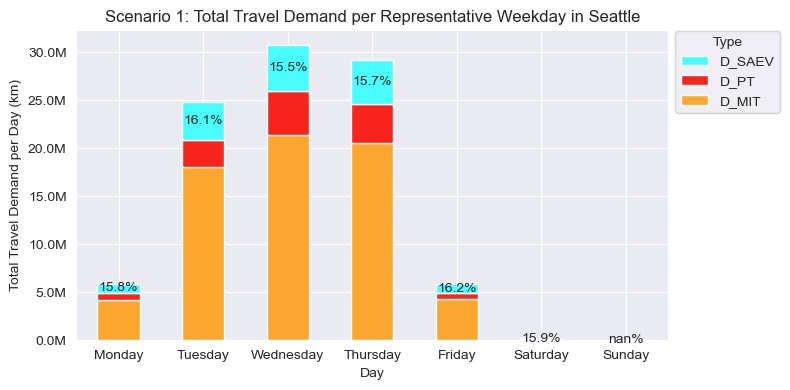

In [127]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['wegkm_imp_hoch_fac_MIV', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 1: Total Travel Demand per Representative Weekday in Seattle')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))


# Show the plot
plt.tight_layout()
plt.show()

## Scenario 2

In [128]:
# Group dfs_tot_MIT_PT_nohw_hw by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', d_opnv_ae_s, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
total_wegkm_day_SAEV['d_saev/d_miv'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac_MIV']
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac']

# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario2 and rename the column in the same line
total_wegkm_day_Scenario2 = total_wegkm_day_SAEV[['day', 'wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_MIV': 'd_mit_ae_s'}).copy()



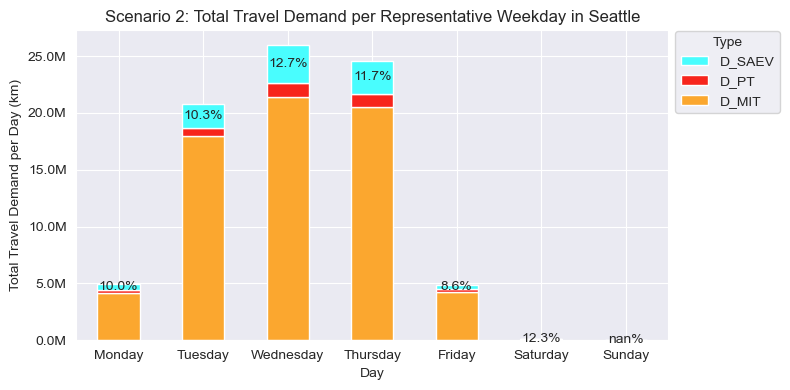

In [129]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['wegkm_imp_hoch_fac_MIV', 'd_opnv_ae_s', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 2: Total Travel Demand per Representative Weekday in Seattle')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))

# Show the plot
plt.tight_layout()
plt.show()

In [130]:
# Initialize an empty DataFrame to store the cumulative sum across all days
week_sum_df = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    if week_sum_df.empty:
        # If week_sum_df is empty, initialize it with the current DataFrame
        week_sum_df = df.copy()
    else:
        # Add the current day's DataFrame to the cumulative sum DataFrame
        week_sum_df = week_sum_df.add(df, fill_value=0)



# Sum each column
week_column_sum_df = week_sum_df.sum(axis=0).to_frame().T



## Scenario 3

In [131]:
# Calculate a new column for all dfs in the dictionary that is called wegkm_saev and calculated by d_miv_ae_s - wegkm_imp_hoch_fac_MIV
for day, df in dfs_interpolated.items():
    df['wegkm_saev'] = df['d_miv_ae_s'] - df['wegkm_imp_hoch_fac_MIV']
    df['d_mit_ae_s'] =  df['wegkm_imp_hoch_fac_MIV'] - df['wegkm_saev']
    

In [132]:
# Group dfs_tot_MIT_PT_nohw_hw by 'wegkm_imp_hoch_fac', 'wegkm_imp_hoch_fac_MIV', d_opnv_ae_s, and 'wegkm_saev' by 'ST_WOTAG' and save in a new df
# Initialize an empty DataFrame to collect the results
total_wegkm_day_SAEV = pd.DataFrame()

# Iterate over the dictionary of DataFrames
for day, df in dfs_interpolated.items():
    # Sum the specified columns for each day DataFrame
    day_sum = df[['wegkm_imp_hoch_fac', 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev']].sum().to_frame().T
    
    # Add the day information (could be an index or a column as needed)
    day_sum['day'] = day
    
    # Append the summed DataFrame to the results
    total_wegkm_day_SAEV = pd.concat([total_wegkm_day_SAEV, day_sum], ignore_index=True)
    
#total_wegkm_day_SAEV['d_saev/d_miv'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac_MIV']
total_wegkm_day_SAEV['d_saev/d_tot'] = total_wegkm_day_SAEV['wegkm_saev'] / total_wegkm_day_SAEV['wegkm_imp_hoch_fac']

# Save only the data that was plotted in a new DataFrame called total_wegkm_day_Scenario3 and rename the column in the same line
total_wegkm_day_Scenario3 = total_wegkm_day_SAEV[['day', 'd_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev', 'd_saev/d_tot']].rename(columns={'wegkm_imp_hoch_fac_PT': 'd_opnv_ae_s'}).copy()



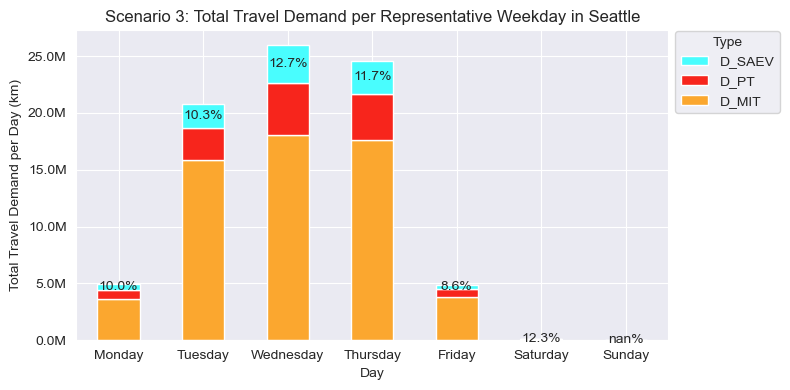

In [133]:
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']

# Plot the data using pandas plot with stacked bars
ax = total_wegkm_day_SAEV.plot(x='day', y=['d_mit_ae_s', 'wegkm_imp_hoch_fac_PT', 'wegkm_saev'], kind='bar', stacked=True, figsize=(8, 4), rot=0, color=custom_colors)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Scenario 3: Total Travel Demand per Representative Weekday in Seattle')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_MIT', 'D_PT', 'D_SAEV']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# The last container corresponds to 'wegkm_saev'
container = ax.containers[-1]
labels = [f'{(v*100):.1f}%' if v != 0 else '' for v in total_wegkm_day_SAEV['d_saev/d_tot']]
ax.bar_label(container, labels=labels, label_type='center')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(millions))


# Show the plot
plt.tight_layout()
plt.show()

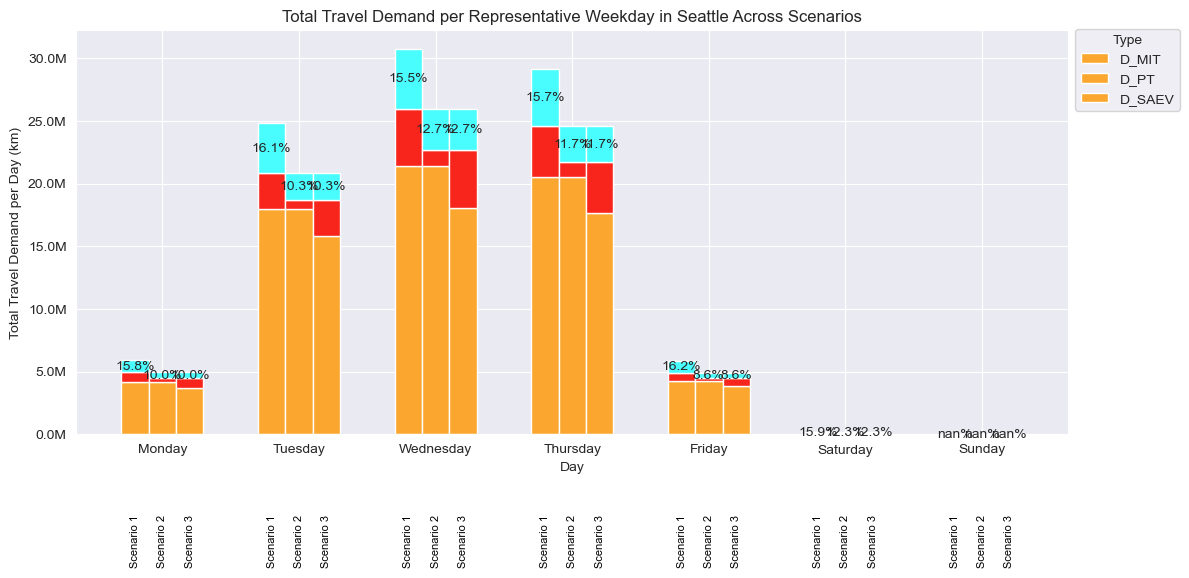

In [134]:
# Custom colors for the types
custom_colors = ['#fba72f', '#f7251c', '#49fdfe']  # Colors for D_MIT, D_PT, D_SAEV

# Assuming you have the data in DataFrames
# total_wegkm_day_Scenario1, total_wegkm_day_Scenario2, total_wegkm_day_Scenario3

# Add a 'Scenario' column to each DataFrame to distinguish between the scenarios
total_wegkm_day_Scenario1['Scenario'] = 'Scenario 1'
total_wegkm_day_Scenario2['Scenario'] = 'Scenario 2'
total_wegkm_day_Scenario3['Scenario'] = 'Scenario 3'

# Combine the DataFrames
combined_df = pd.concat([total_wegkm_day_Scenario1, total_wegkm_day_Scenario2, total_wegkm_day_Scenario3])

# Ensure 'day' is treated as a categorical variable to control the order
combined_df['day'] = pd.Categorical(combined_df['day'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Sort by 'day' and 'Scenario' to ensure correct plotting order
combined_df = combined_df.sort_values(['day', 'Scenario'])

# Create a pivot table for plotting
pivot_df = combined_df.pivot_table(index='day', columns='Scenario', values=['d_mit_ae_s', 'd_opnv_ae_s', 'wegkm_saev', 'd_saev/d_tot'])

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set the positions of the bars on the x-axis
positions = np.arange(len(pivot_df))

# Plot the data for each scenario
for i, scenario in enumerate(pivot_df.columns.levels[1]):
    scenario_data = pivot_df.xs(scenario, level='Scenario', axis=1)
    bars_mit = ax.bar(positions + i * bar_width, scenario_data['d_mit_ae_s'], bar_width, label=f'Scenario {i+1}', color=custom_colors[0])
    bars_opnv = ax.bar(positions + i * bar_width, scenario_data['d_opnv_ae_s'], bar_width, bottom=scenario_data['d_mit_ae_s'], color=custom_colors[1])
    bars_saev = ax.bar(positions + i * bar_width, scenario_data['wegkm_saev'], bar_width, bottom=scenario_data['d_mit_ae_s'] + scenario_data['d_opnv_ae_s'], color=custom_colors[2])

    # Add labels below the bars indicating the scenario
    for bar in bars_saev:
        ax.text(
            bar.get_x() + bar.get_width() / 2, 
            -0.2,  # Adjust this value for positioning below the x-axis
            f'Scenario {i+1}', 
            ha='center', 
            va='top', 
            fontsize=8, 
            rotation = 90,
            color='black', 
            transform=ax.get_xaxis_transform()  # Ensures the text is positioned relative to the x-axis
        )

# Add percentage labels for 'wegkm_saev' for each scenario explicitly
# Scenario 1
container_scenario_1 = ax.containers[2]  # The container for Scenario 1 'wegkm_saev' bars
labels_scenario_1 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 1')]]
ax.bar_label(container_scenario_1, labels=labels_scenario_1, label_type='center')

# Scenario 2
container_scenario_2 = ax.containers[5]  # The container for Scenario 2 'wegkm_saev' bars
labels_scenario_2 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 2')]]
ax.bar_label(container_scenario_2, labels=labels_scenario_2, label_type='center')

# Scenario 3
container_scenario_3 = ax.containers[8]  # The container for Scenario 3 'wegkm_saev' bars
labels_scenario_3 = [f'{(v * 100):.1f}%' if v != 0 else '' for v in pivot_df[('d_saev/d_tot', 'Scenario 3')]]
ax.bar_label(container_scenario_3, labels=labels_scenario_3, label_type='center')

# Set x-axis labels
ax.set_xticks(positions + bar_width)
ax.set_xticklabels(pivot_df.index)

# Set title and labels
ax.set_xlabel('Day')
ax.set_ylabel('Total Travel Demand per Day (km)')
ax.set_title('Total Travel Demand per Representative Weekday in Seattle Across Scenarios')

# Customize the legend with new labels
handles, labels = ax.get_legend_handles_labels()
labels = ['D_SAEV', 'D_PT', 'D_MIT']
ax.legend(handles[::-1], labels[::-1], title='Type', bbox_to_anchor=(1, 1.02), loc='upper left')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Apply tight layout
plt.tight_layout()

# Show the plot
plt.show()

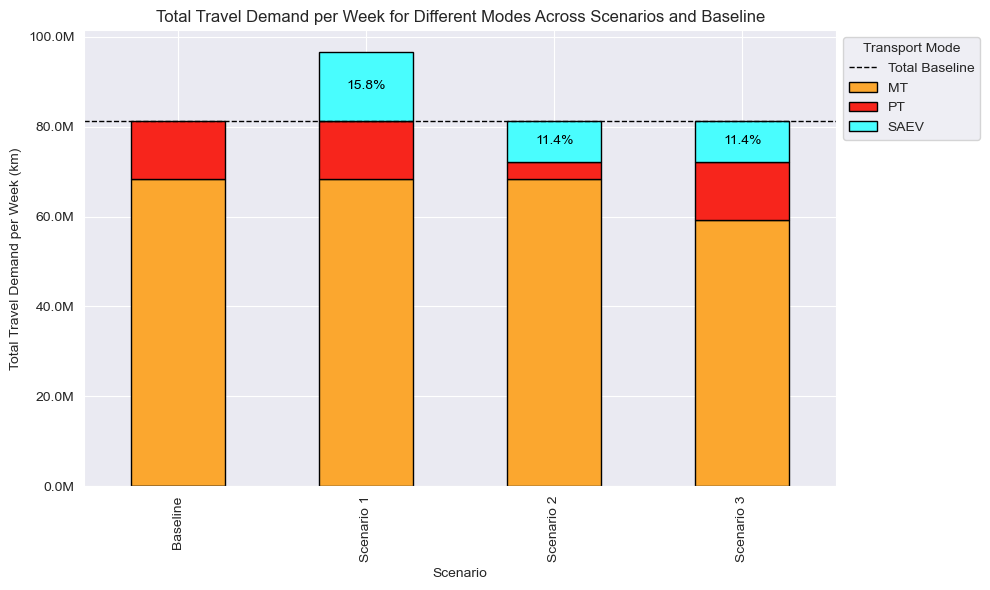

In [135]:
# Compute total travel demand per week for each mode across all scenarios
total_demand_week = pd.DataFrame({
    'MT': [pivot_df[('d_mit_ae_s', 'Scenario 1')].sum(), pivot_df[('d_mit_ae_s', 'Scenario 2')].sum(), pivot_df[('d_mit_ae_s', 'Scenario 3')].sum()],
    'PT': [pivot_df[('d_opnv_ae_s', 'Scenario 1')].sum(), pivot_df[('d_opnv_ae_s', 'Scenario 2')].sum(), pivot_df[('d_opnv_ae_s', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('wegkm_saev', 'Scenario 1')].sum(), pivot_df[('wegkm_saev', 'Scenario 2')].sum(), pivot_df[('wegkm_saev', 'Scenario 3')].sum()]
}, index=['Scenario 1', 'Scenario 2', 'Scenario 3'])

# Baseline data: Calculate the total baseline travel demand per week for each mode
baseline_demand = {
    'MT': daily_totals['wegkm_imp_hoch_fac_MIV'].sum(),  # Total demand over the whole week for MT
    'PT': daily_totals['wegkm_imp_hoch_fac_PT'].sum(),  # Total demand over the whole week for PT
    'SAEV': 0  # Assuming no baseline value for SAEV
}

# Add baseline data as a separate DataFrame
baseline_df_demand = pd.DataFrame({
    'MT': [baseline_demand['MT']],
    'PT': [baseline_demand['PT']],
    'SAEV': [baseline_demand['SAEV']]
}, index=['Baseline'])

# Calculate the total baseline for the horizontal line
total_baseline_demand = baseline_df_demand.sum(axis=1).values[0]

# Concatenate baseline data with scenario data
combined_data_demand = pd.concat([baseline_df_demand, total_demand_week])

# Custom colors for the bars to match the original plot colors
bar_colors_demand = ['#fba72f', '#f7251c', '#49fdfe']  # MT, PT, SAEV

# Plotting the stacked bar chart for travel demand
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each mode as a stacked bar with cyan outline for SAEV
combined_data_demand[['MT', 'PT', 'SAEV']].plot(
    kind='bar', 
    stacked=True, 
    color=bar_colors_demand, 
    ax=ax, 
    edgecolor=['black', 'black', 'black']  # Cyan outline for SAEV
)

# Draw a single horizontal dotted line for the total baseline
ax.axhline(total_baseline_demand, color='black', linestyle='--', linewidth=1, label='Total Baseline')

# Add percentage labels for 'SAEV' for each scenario explicitly
for i, scenario in enumerate(combined_data_demand.index):
    if combined_data_demand['SAEV'][i] > 0:  # Only add labels for non-zero SAEV values
        saev_percent = (combined_data_demand['SAEV'][i] / combined_data_demand.loc[scenario].sum()) * 100
        ax.text(i, combined_data_demand.loc[scenario].sum() - combined_data_demand['SAEV'][i] / 2, 
                f'{saev_percent:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Set labels and title
ax.set_xlabel('Scenario')
ax.set_ylabel('Total Travel Demand per Week (km)')
ax.set_title('Total Travel Demand per Week for Different Modes Across Scenarios and Baseline')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Customize the legend
ax.legend(title='Transport Mode', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()


# Show plot
plt.show()

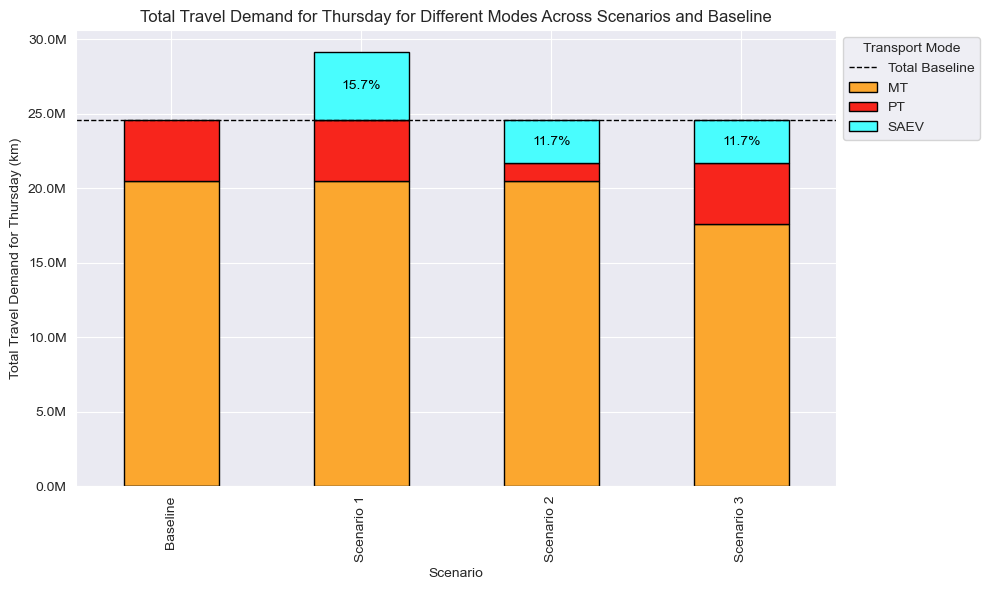

In [136]:
# Ensure 'daily_totals' is properly filtered for Thursday
thursday_daily_totals = daily_totals[daily_totals['Day'] == 'Thursday']

# Compute total travel demand per mode for Thursday across all scenarios
total_demand_thursday = pd.DataFrame({
    'MT': [pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_mit_ae_s', 'Scenario 1')].sum(), 
           pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_mit_ae_s', 'Scenario 2')].sum(), 
           pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_mit_ae_s', 'Scenario 3')].sum()],
    
    'PT': [pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_opnv_ae_s', 'Scenario 1')].sum(), 
           pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_opnv_ae_s', 'Scenario 2')].sum(), 
           pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('d_opnv_ae_s', 'Scenario 3')].sum()],
    
    'SAEV': [pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('wegkm_saev', 'Scenario 1')].sum(), 
             pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('wegkm_saev', 'Scenario 2')].sum(), 
             pivot_df.loc[pivot_df.index.get_level_values('day') == 'Thursday', ('wegkm_saev', 'Scenario 3')].sum()]
}, index=['Scenario 1', 'Scenario 2', 'Scenario 3'])

# Compute baseline travel demand for Thursday
baseline_demand_thursday = {
    'MT': thursday_daily_totals['wegkm_imp_hoch_fac_MIV'].sum(),
    'PT': thursday_daily_totals['wegkm_imp_hoch_fac_PT'].sum(),
    'SAEV': 0  # Assuming no baseline value for SAEV
}

# Create baseline DataFrame for Thursday
baseline_df_demand_thursday = pd.DataFrame({
    'MT': [baseline_demand_thursday['MT']],
    'PT': [baseline_demand_thursday['PT']],
    'SAEV': [baseline_demand_thursday['SAEV']]
}, index=['Baseline'])

# Calculate total baseline for the horizontal line
total_baseline_demand_thursday = baseline_df_demand_thursday.sum(axis=1).values[0]

# Concatenate baseline data with scenario data
combined_data_demand_thursday = pd.concat([baseline_df_demand_thursday, total_demand_thursday])

# Define colors for the bars
bar_colors_demand = ['#fba72f', '#f7251c', '#49fdfe']  # MT, PT, SAEV

# Plotting the stacked bar chart for travel demand (Thursday)
fig, ax = plt.subplots(figsize=(10, 6))

# Stacked bar plot
combined_data_demand_thursday[['MT', 'PT', 'SAEV']].plot(
    kind='bar', 
    stacked=True, 
    color=bar_colors_demand, 
    ax=ax, 
    edgecolor=['black', 'black', 'black']
)

# Draw a horizontal dashed line for total baseline (Thursday)
ax.axhline(total_baseline_demand_thursday, color='black', linestyle='--', linewidth=1, label='Total Baseline')

# Add percentage labels for 'SAEV' for each scenario
for i, scenario in enumerate(combined_data_demand_thursday.index):
    if combined_data_demand_thursday['SAEV'][i] > 0:  # Only add labels for non-zero SAEV values
        saev_percent = (combined_data_demand_thursday['SAEV'][i] / combined_data_demand_thursday.loc[scenario].sum()) * 100
        ax.text(i, combined_data_demand_thursday.loc[scenario].sum() - combined_data_demand_thursday['SAEV'][i] / 2, 
                f'{saev_percent:.1f}%', ha='center', va='center', fontsize=10, color='black')

# Set labels and title
ax.set_xlabel('Scenario')
ax.set_ylabel('Total Travel Demand for Thursday (km)')
ax.set_title('Total Travel Demand for Thursday for Different Modes Across Scenarios and Baseline')

# Apply custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Customize the legend
ax.legend(title='Transport Mode', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()

# Show the plot
plt.show()

In [137]:
import copy

# Create a deep copy of the original dictionary
dfs_tot_MIT_PT_nohw_hw_copy = copy.deepcopy(dfs_tot_MIT_PT_nohw_hw)

# Emission Model

In [138]:
# Specify path for EmissionDatav2.xlsx
# EmissionDatapath = 
params_df = pd.read_excel(EmissionDatapath, sheet_name='Seattle')

### Emissions from operations 

In [139]:
# Convert DataFrame to a dictionary for base values
base_values = params_df.set_index('Parameter')['Base value'].to_dict()
Conversionrate_l_g = base_values['Conversionrate_l_g']
Conversionrate_k_m = base_values['Conversionrate_k_m']
e_Conv_Bus = base_values['E_Conv_Bus'] / Conversionrate_k_m  # Emission factor conventional bus per km [kg/km]
e_MIV = 0.38/1.60934
e_MIV2 = ((base_values['Proportion_Gasoline'] * base_values['Consumption_Gasoline'] * base_values['Emissionfactor_Gasoline'] + base_values['Proportion_Diesel'] * base_values['Consumption_Diesel'] * base_values['Emissionfactor_Diesel'] + base_values['Proportion_BEV'] * base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_conv'] )/base_values['Occupancy_Rate_conv'])/ Conversionrate_k_m 
e_AEV_conv = base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_conv'] / base_values['Occupancy_Rate_AEV']
e_AEV_renew = base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_renew'] / base_values['Occupancy_Rate_AEV']
e_SAEV = (base_values['Consumption_BEV'] * base_values['Emissionfactor_BEV_renew'] )/ base_values['Occupancy_Rate_SAEV']


In [140]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_emissions(row):
    E_MIV_1 = row ['wegkm_imp_hoch_fac_MIV'] * e_MIV /1000
    E_OPNV_1 = row ['wegkm_imp_hoch_fac_PT'] * e_Conv_Bus /1000
    return pd.Series([E_MIV_1, E_OPNV_1])

for day, df in dfs_tot_MIT_PT_nohw_hw.items():
# Apply the function to each row
    df[['E_MIV_1', 'E_OPNV_1']] = df.apply(calculate_emissions, axis=1)


In [141]:
# Function to calculate D_MIV_neu, D_OPNV_neu, and D_MIV_AE_S based on conditions
def calculate_emissions_SAEV(row):
    E_SAEV_2 = row['wegkm_saev'] * e_SAEV/1000
    E_AEV_2 = row['wegkm_saev'] * e_AEV_conv/1000
    E_MIV_2 = row ['d_mit_ae_s'] * e_MIV/1000
    E_OPNV_2 = row ['d_opnv_ae_s'] * e_Conv_Bus/1000
    return pd.Series([E_SAEV_2,E_AEV_2, E_MIV_2, E_OPNV_2])


# Apply the function to calculate emissions for each row and update specific columns
for column in combined_df.columns:
    combined_df[['E_SAEV_2', 'E_AEV_2', 'E_MIV_2', 'E_OPNV_2']] = combined_df.apply(calculate_emissions_SAEV, axis=1)

In [142]:
# Initialize lists to hold the cumulative integrals and day labels across all days

cumulative_MIV_1 = []
cumulative_OPNV_1 = []
cumulative_sum_1 = []

day_labels = []

# Initialize variables to accumulate the cumulative sum over days
total_integral_MIV_1 = 0.0
total_integral_OPNV_1 = 0.0

# Custom colors for the lines and shaded areas
line_colors = ['#49fdfe', '#f7251c', '#fba72f']  # Colors for D_SAEV, D_PT, D_MIT
area_colors = ['#b3e5fc', '#f8bbd0', '#ffe0b2']  # Lighter shades for the areas
total_line_color = '#0000FF'  # Color for the total line
total_area_color = '#add8e6'  # Lighter shade for the total area

# Create a pivot table for plotting
pivot_df = combined_df.pivot_table(index='day', columns='Scenario', values=['E_SAEV_2', 'E_MIV_2', 'E_OPNV_2'])

# Calculate the total demand for each scenario
pivot_df['total', 'Scenario 1'] = pivot_df[('E_MIV_2', 'Scenario 1')] + pivot_df[('E_OPNV_2', 'Scenario 1')] + pivot_df[('E_SAEV_2', 'Scenario 1')]
pivot_df['total', 'Scenario 2'] = pivot_df[('E_MIV_2', 'Scenario 2')] + pivot_df[('E_OPNV_2', 'Scenario 2')] + pivot_df[('E_SAEV_2', 'Scenario 2')]
pivot_df['total', 'Scenario 3'] = pivot_df[('E_MIV_2', 'Scenario 3')] + pivot_df[('E_OPNV_2', 'Scenario 3')] + pivot_df[('E_SAEV_2', 'Scenario 3')]

# Compute the cumulative sum for each scenario
for scenario in ['Scenario 1', 'Scenario 2', 'Scenario 3']:
    pivot_df[('cumulative_E_mit', scenario)] = pivot_df[('E_MIV_2', scenario)].cumsum()
    pivot_df[('cumulative_E_opnv', scenario)] = pivot_df[('E_OPNV_2', scenario)].cumsum()
    pivot_df[('cumulative_E_saev', scenario)] = pivot_df[('E_SAEV_2', scenario)].cumsum()
    pivot_df[('cumulative_total', scenario)] = pivot_df[('total', scenario)].cumsum()


# Iterate over each day to compute the cumulative integrals
for day, df in dfs_tot_MIT_PT_nohw_hw.items():
    # Ensure that the DataFrame is sorted by index (time) to correctly apply the trapezoidal rule
    df = df.sort_index()
    # Fill NaN values with zeroes
    df['E_MIV_1'].fillna(0, inplace=True)
    df['E_OPNV_1'].fillna(0, inplace=True)


    integral_MIV_1 = np.trapz(df['E_MIV_1'].values, dx=1)
    total_integral_MIV_1 += integral_MIV_1
    cumulative_MIV_1.append(total_integral_MIV_1)

    integral_OPNV_1 = np.trapz(df['E_OPNV_1'].values, dx=1)
    total_integral_OPNV_1 += integral_OPNV_1
    cumulative_OPNV_1.append(total_integral_OPNV_1)

    # Store the day labels for x-axis
    day_labels.append(day)


# Calculate the cumulative sums
for i in range(len(cumulative_MIV_1)):
    sum_1 = cumulative_MIV_1[i] + cumulative_OPNV_1[i]
    cumulative_sum_1.append(sum_1)

In [143]:
# Compute the total emissions per week for each mode across all scenarios
total_emissions_week = pd.DataFrame({
    'MT': [pivot_df[('E_MIV_2', 'Scenario 1')].sum(), pivot_df[('E_MIV_2', 'Scenario 2')].sum(), pivot_df[('E_MIV_2', 'Scenario 3')].sum()],
    'PT': [pivot_df[('E_OPNV_2', 'Scenario 1')].sum(), pivot_df[('E_OPNV_2', 'Scenario 2')].sum(), pivot_df[('E_OPNV_2', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('E_SAEV_2', 'Scenario 1')].sum(), pivot_df[('E_SAEV_2', 'Scenario 2')].sum(), pivot_df[('E_SAEV_2', 'Scenario 3')].sum()],
    'Total': [
        pivot_df[('total', 'Scenario 1')].sum(),
        pivot_df[('total', 'Scenario 2')].sum(),
        pivot_df[('total', 'Scenario 3')].sum()
    ],
    'Scenario': ['Scenario 1', 'Scenario 2', 'Scenario 3']
})

# Baseline data: Calculate the total baseline emissions per week for each mode
baseline_data = {
    'MT': cumulative_MIV_1[-1],  # Total emissions over the whole week for MT
    'PT': cumulative_OPNV_1[-1],  # Total emissions over the whole week for PT
    'SAEV': 0,  # Assuming no baseline value for SAEV, set to 0 or another relevant value
    'Total': cumulative_sum_1[-1]  # Total emissions over the whole week for all modes
}



In [144]:
# Compute total emissions per week for each mode across all scenarios
total_emissions_week = pd.DataFrame({
    'MT': [pivot_df[('E_MIV_2', 'Scenario 1')].sum(), pivot_df[('E_MIV_2', 'Scenario 2')].sum(), pivot_df[('E_MIV_2', 'Scenario 3')].sum()],
    'PT': [pivot_df[('E_OPNV_2', 'Scenario 1')].sum(), pivot_df[('E_OPNV_2', 'Scenario 2')].sum(), pivot_df[('E_OPNV_2', 'Scenario 3')].sum()],
    'SAEV': [pivot_df[('E_SAEV_2', 'Scenario 1')].sum(), pivot_df[('E_SAEV_2', 'Scenario 2')].sum(), pivot_df[('E_SAEV_2', 'Scenario 3')].sum()]
}, index=['Scenario 1', 'Scenario 2', 'Scenario 3'])

# Baseline data: Calculate the total baseline emissions per week for each mode
baseline_data = {
    'MT': cumulative_MIV_1[-1],  # Total emissions over the whole week for MT
    'PT': cumulative_OPNV_1[-1],  # Total emissions over the whole week for PT
    'SAEV': 0  # Assuming no baseline value for SAEV, set to 0 or another relevant value
}

# Add baseline data as a separate DataFrame
baseline_df = pd.DataFrame({
    'MT': [baseline_data['MT']],
    'PT': [baseline_data['PT']],
    'SAEV': [baseline_data['SAEV']]
}, index=['Baseline'])

# Calculate the total baseline for the horizontal line
total_baseline = baseline_df.sum(axis=1).values[0]

# Concatenate baseline data with scenario data
combined_data = pd.concat([baseline_df, total_emissions_week])

In [145]:
# Baseline total emissions
baseline_total_emissions = baseline_df.sum(axis=1).values[0]

# Total emissions for each scenario
scenario_totals = total_emissions_week.sum(axis=1)

# Calculate the relative change from the baseline to each scenario
relative_changes = ((scenario_totals - baseline_total_emissions) / baseline_total_emissions) * 100

# Create a DataFrame to display the relative changes
relative_changes_df = pd.DataFrame({
    'Scenario': ['Scenario 1', 'Scenario 2', 'Scenario 3'],
    'Relative Change (%)': relative_changes.values
})


### Emissions from production & End-of-life

#### Fleet size: 

Li et al:
We examine three different assumptions for the growth of the SAEV fleet based on different proportions of current Uber and Lyft market size, which is around 96,000 vehicles in the San Francisco Bay Area of California. Under medium adoption level, the SAEV fleet will be as large as 10% of current TNC market by 2030. And the low and high adoption levels correspond to 5% and 25% respectively. We assume a linear growth in the market adoption from 0% in 2021 to 2030.


For the remaining part of the Results section, one scenario was analyzed in more detail. The 10% demand–10% fleet scenario was chosen as an example because it combines a large demand with a small fleet, which introduces competition for AVs in the scenario (Bösch Paper)


In [146]:
# Extract individual values from the dictionary
Fleetsize = base_values['Fleet_Seattle']   # Emission factor conventional bus per km [t/km]

#Scanrio builder
Fleetproportion = 0.1
Private_Vehicle_Replacement_Rate = 4
Fleetsize_SAEV = round(Fleetproportion * Fleetsize)
Fleetsize_private =round( Fleetsize- (Fleetsize_SAEV/Private_Vehicle_Replacement_Rate))

print(Fleetsize_SAEV)
print(Fleetsize_private)

46100
449475


In [147]:
# Load excel file
# Specify path for EmissionDatav2.xlsx
#params_path =
params_df = pd.read_excel(EmissionDatapath, sheet_name='VehSea')  

# Entfernen der Spalten I bis M
emission_df = params_df.drop(params_df.columns[8:13], axis=1)  # Spaltenindex 8 entspricht Spalte I, und 13 entspricht Spalte M

# Behalten von nur den Zeilen 0 (Header), 1, 2, 10, und 12 (Python indexiert ab 0)
emission_df = emission_df.iloc[[1, 2, 9, 9,11]]

# Hinzufügen einer neuen Spalte 'Modell' mit den entsprechenden Werten
emission_df.loc[1, 'Modell'] = 'E_Conv_Car_Gasoline'
emission_df.loc[2, 'Modell'] = 'E_Conv_Car_Diesel'
# Rename the first occurrence of row with index 9 in the 'Modell' column 
emission_df.iloc[emission_df.index.get_indexer_for([9])[0], emission_df.columns.get_loc('Modell')] = 'E_EA_PooledTaxi/Ind.Taxi'
# Rename the second occurrence of row with index 9 in the 'Modell' column 
emission_df.iloc[emission_df.index.get_indexer_for([9])[1], emission_df.columns.get_loc('Modell')] = 'E_Conv_Car_BEV'
emission_df.loc[11, 'Modell'] = 'E_Conv_Bus'

# Platzieren der neuen Spalte 'Modell' ganz vorne im DataFrame
emission_df = emission_df[['Modell'] + [col for col in emission_df.columns if col != 'Modell']]

# Konvertieren der Spalte 'Curb Weight (kg)' in numerische Werte (float)
emission_df['Curb Weight (kg)'] = pd.to_numeric(emission_df['Curb Weight (kg)'], errors='coerce')

# Variable für Produktionsemissionen
production_emissions_vehicle_body = 4.56 #kg CO2 − eq.∕kg
production_emissions_battery_pack = 83.50 #kg CO2 − eq.∕kWh

#Variable for Recyling emission
recycling_emissions_vehicle_body = 2.93#kg CO2 − eq.∕kg
recycling_emissions_battery_pack = 48.4 #kg CO2 − eq.∕kWh


# Multipliziere die Spalte 'Curb Weight (kg)' mit der Variable 'production_emissions_vehicle_body'
emission_df['Production Emissions (kg Co2 Eq)'] = emission_df['Curb Weight (kg)'] * production_emissions_vehicle_body + emission_df['Battery Gross Capacity (kWh)'] * production_emissions_battery_pack

# Multipliziere die Spalte 'Curb Weight (kg)' mit der Variable 'recycling_emissions_vehicle_body'
emission_df['Recycling Emissions (kg Co2 Eq)'] = -(emission_df['Curb Weight (kg)'] * recycling_emissions_vehicle_body) - (emission_df['Battery Gross Capacity (kWh)'] * recycling_emissions_battery_pack)

# Am Ende alle Spalten außer der ersten und letzten löschen
emission_df = emission_df.iloc[:, [0, -1, -2]]

#### Emissions from production

In [148]:
lifetime = 15.7  # Buberger
ProportionDiesel = 0.29
ProportionBenzin = 0.62
ProportionBEV = 0.09
# https://www.kba.de/DE/Statistik/Fahrzeuge/Bestand/Jahrebilanz_Bestand/fz_b_jahresbilanz_node.html#:~:text=Mit%2049.098.685%20Einheiten%20und,8%20%25)%20die%20h%C3%A4ufigsten%20Kraftstoffarten.

production_emissions_afterSAEV = Fleetsize_SAEV * (emission_df.loc[
    emission_df['Modell'].str.strip() == 'E_EA_PooledTaxi/Ind.Taxi', 'Production Emissions (kg Co2 Eq)'].values[
    0]) + Fleetsize_private * (ProportionDiesel * (
emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Production Emissions (kg Co2 Eq)'].values[
    0]) + ProportionBenzin * (emission_df.loc[
    emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Production Emissions (kg Co2 Eq)'].values[
    0]) + ProportionBEV * (emission_df.loc[
    emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Production Emissions (kg Co2 Eq)'].values[0]))

production_emissions_preSAEV = Fleetsize * (ProportionDiesel * (
emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Production Emissions (kg Co2 Eq)'].values[
    0]) + ProportionBenzin * (emission_df.loc[
    emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Production Emissions (kg Co2 Eq)'].values[
    0]) + ProportionBEV * (emission_df.loc[
    emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Production Emissions (kg Co2 Eq)'].values[0]))

production_emissions_savings = production_emissions_afterSAEV - production_emissions_preSAEV

print(production_emissions_savings)

463821400.09647846


#### Emissions from End-of-life

In [149]:
recycling_emissions_afterSAEV = Fleetsize_SAEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_EA_PooledTaxi/Ind.Taxi', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + Fleetsize_private * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Recycling Emissions (kg Co2 Eq)'].values[0]))

recycling_emissions_preSAEV = Fleetsize * (ProportionDiesel  * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Diesel', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBenzin * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_Gasoline', 'Recycling Emissions (kg Co2 Eq)'].values[0]) + ProportionBEV * (emission_df.loc[emission_df['Modell'].str.strip() == 'E_Conv_Car_BEV', 'Recycling Emissions (kg Co2 Eq)'].values[0]))

recycling_emissions_savings =   recycling_emissions_afterSAEV - recycling_emissions_preSAEV


### Lifecycle Emissions

#### Scenario 1

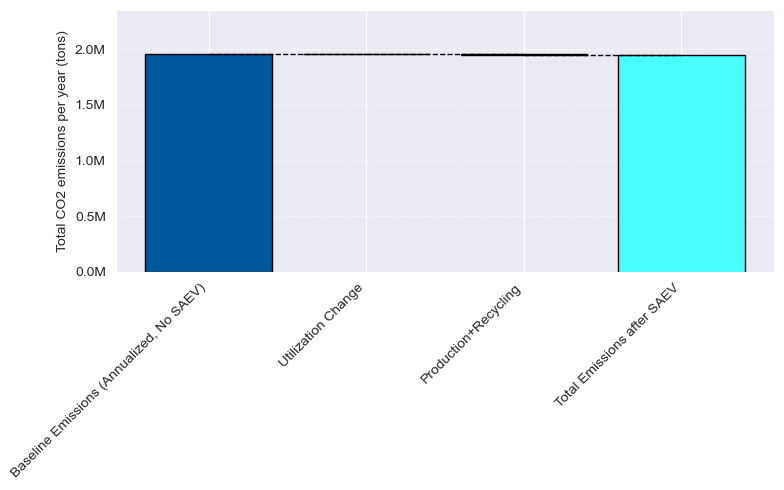

In [150]:
# Extract Thursday's baseline emissions from Scenario 1 (excluding SAEV)
thursday_baseline_emissions = pivot_df.loc['Thursday', ('E_MIV_2', 'Scenario 1')] + \
                              pivot_df.loc['Thursday', ('E_OPNV_2', 'Scenario 1')]  # Excluding E_SAEV_2

# **Scaling factor: 365 days for full-year emissions**
scaling_factor = 365  

# **Scale total baseline emissions for the year (without SAEV)**
total_value = (((production_emissions_preSAEV / 1000) / lifetime) + 
               (thursday_baseline_emissions * scaling_factor) + 
               ((recycling_emissions_preSAEV / 1000) / lifetime))

# **Scale only the emission changes (blocks) over 365 days**
first_block = pivot_df.loc['Thursday', ('E_SAEV_2', 'Scenario 1')]* scaling_factor
second_block = ((production_emissions_savings / 1000) / lifetime) + ((recycling_emissions_savings / 1000) / lifetime)
third_block = total_value + first_block - second_block

blocks = [first_block, second_block, third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]  # **Now using scaled baseline emissions**
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side (Scaled Baseline Emissions)
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Baseline Emissions (Annualized, No SAEV)')

# Plot the waterfall blocks (Scaled impacts)
for i in range(3):
    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=colors[i], edgecolor='black')

# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 3):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Baseline Emissions (Annualized, No SAEV)', 'Utilization Change', 'Production+Recycling', 'Total Emissions after SAEV'])

# Set title and labels
ax.set_ylabel('Total CO2 emissions per year (tons)')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')

# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed

plt.tight_layout()
plt.show()


In [151]:


# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)

# Display the DataFrame
print(emission_reduction_df)


                                         Description         Value
0                    Total Emissions pre SAEV (tons)  1.961097e+06
1                        Operations Reduction (tons)  3.431130e+03
2            Production + Recycling Reduction (tons)  1.143463e+04
3                  Total Emissions after SAEV (tons)  1.953094e+06
4  Percentage Reduction from pre SAEV to post SAE... -4.081134e-01


#### Scenario 2

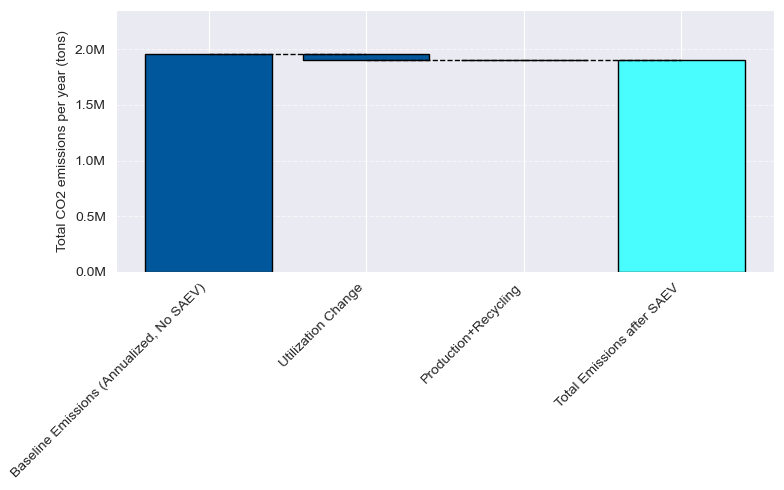

In [152]:
# Extract Thursday's baseline emissions from Scenario 1 (excluding SAEV)
thursday_baseline_emissions = pivot_df.loc['Thursday', ('E_MIV_2', 'Scenario 1')] + \
                              pivot_df.loc['Thursday', ('E_OPNV_2', 'Scenario 1')]  # Excluding E_SAEV_2

# **Scaling factor: 365 days for full-year emissions**
scaling_factor = 365  

# **Scale total baseline emissions for the year (without SAEV)**
total_value = (((production_emissions_preSAEV / 1000) / lifetime) + 
               (thursday_baseline_emissions * scaling_factor) + 
               ((recycling_emissions_preSAEV / 1000) / lifetime))

# **Scale only the emission changes (blocks) over 365 days**
first_block = -((pivot_df.loc['Thursday', ('total', 'Scenario 2')] * scaling_factor) - 
               (thursday_baseline_emissions * scaling_factor))  


second_block = 0
third_block = total_value - first_block - second_block

blocks = [first_block, second_block, third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]  # **Now using scaled baseline emissions**
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side (Scaled Baseline Emissions)
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Baseline Emissions (Annualized, No SAEV)')

# Plot the waterfall blocks (Scaled impacts)
for i in range(3):
    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=colors[i], edgecolor='black')

# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 3):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Baseline Emissions (Annualized, No SAEV)', 'Utilization Change', 'Production+Recycling', 'Total Emissions after SAEV'])

# Set title and labels
ax.set_ylabel('Total CO2 emissions per year (tons)')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')

# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed

plt.tight_layout()
plt.show()

In [153]:


# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)

# Display the DataFrame
print(emission_reduction_df)

                                         Description         Value
0                    Total Emissions pre SAEV (tons)  1.961097e+06
1                        Operations Reduction (tons)  6.143459e+04
2            Production + Recycling Reduction (tons)  0.000000e+00
3                  Total Emissions after SAEV (tons)  1.899663e+06
4  Percentage Reduction from pre SAEV to post SAE... -3.132664e+00


#### Scenario 3

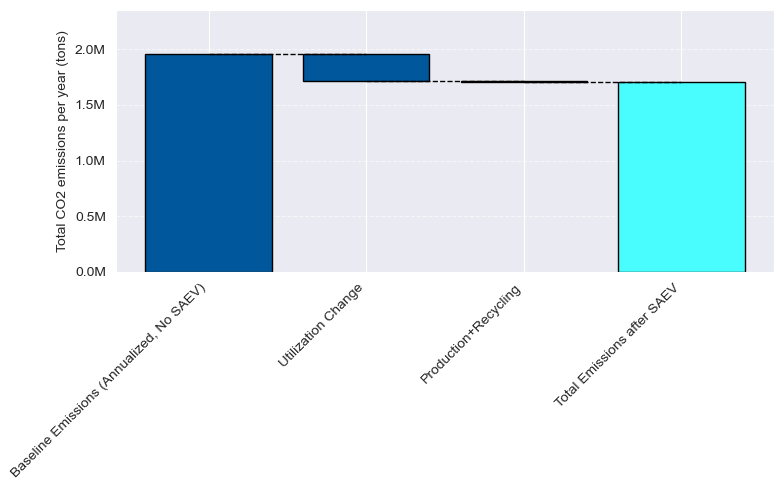

In [154]:
# Extract Thursday's baseline emissions from Scenario 1 (excluding SAEV)
thursday_baseline_emissions = pivot_df.loc['Thursday', ('E_MIV_2', 'Scenario 1')] + \
                              pivot_df.loc['Thursday', ('E_OPNV_2', 'Scenario 1')]  # Excluding E_SAEV_2

# **Scaling factor: 365 days for full-year emissions**
scaling_factor = 365  

# **Scale total baseline emissions for the year (without SAEV)**
total_value = (((production_emissions_preSAEV / 1000) / lifetime) + 
               (thursday_baseline_emissions * scaling_factor) + 
               ((recycling_emissions_preSAEV / 1000) / lifetime))

# **Scale only the emission changes (blocks) over 365 days**
first_block = -((pivot_df.loc['Thursday', ('total', 'Scenario 3')] * scaling_factor) - 
               (thursday_baseline_emissions * scaling_factor))  


second_block = ((production_emissions_savings / 1000) / lifetime) + ((recycling_emissions_savings / 1000) / lifetime)
third_block = total_value - first_block - second_block

blocks = [first_block, second_block, third_block]

# Calculate the cumulative values to create a falling waterfall
cumulative = [total_value]  # **Now using scaled baseline emissions**
for block in blocks:
    cumulative.append(cumulative[-1] - block)

# Plotting the waterfall diagram
fig, ax = plt.subplots(figsize=(8, 5))

# Define colors for the bars (similar shades)
colors = ['#01579b', '#0288d1', '#49fdfe']  # Different shades of blue for the blocks

# Plot the initial total bar on the left side (Scaled Baseline Emissions)
ax.bar(0, total_value, color=colors[0], edgecolor='black', label='Baseline Emissions (Annualized, No SAEV)')

# Plot the waterfall blocks (Scaled impacts)
for i in range(3):
    ax.bar(i + 1, -blocks[i], bottom=cumulative[i], color=colors[i], edgecolor='black')

# Draw lines connecting the bars to create the waterfall effect
for i in range(0, 3):
    ax.plot([i, i + 1], [cumulative[i], cumulative[i]], color='black', linestyle='--', linewidth=1)

# Add labels for the bars
ax.set_xticks(range(4))
ax.set_xticklabels(['Baseline Emissions (Annualized, No SAEV)', 'Utilization Change', 'Production+Recycling', 'Total Emissions after SAEV'])

# Set title and labels
ax.set_ylabel('Total CO2 emissions per year (tons)')

# Apply the custom formatter to the y-axis
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

# Add gridlines
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.xticks(rotation=45, ha='right')

# Scale the y-axis higher for better visibility
ax.set_ylim([0, total_value * 1.2])  # Adjust this multiplier as needed

plt.tight_layout()
plt.show()

In [155]:


# Create the DataFrame to calculate and display the values
data = {
    'Description': [
        'Total Emissions pre SAEV (tons)',
        'Operations Reduction (tons)',
        'Production + Recycling Reduction (tons)',
        'Total Emissions after SAEV (tons)',
        'Percentage Reduction from pre SAEV to post SAEV (%)'
    ],
    'Value': [
        total_value,
        first_block,
        second_block,
        #cumulative[-1],
        third_block,
        ((third_block-total_value) / total_value) * 100
    ]
}

# Create the DataFrame
emission_reduction_df = pd.DataFrame(data)

# Display the DataFrame
print(emission_reduction_df)

                                         Description         Value
0                    Total Emissions pre SAEV (tons)  1.961097e+06
1                        Operations Reduction (tons)  2.461360e+05
2            Production + Recycling Reduction (tons)  1.143463e+04
3                  Total Emissions after SAEV (tons)  1.703527e+06
4  Percentage Reduction from pre SAEV to post SAE... -1.313401e+01
